In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc

import statsmodels.api as sm
import lightgbm as lgb
from catboost import CatBoostRegressor

import pickle

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


from data import *
from feature_engineering import *
from tqdm.auto import tqdm

In [54]:
load_all_items_query = "select * from coffee_bean_bean"
load_all_reviews_query = "select * from coffee_bean_beanreview"
items = load_table(load_all_items_query)
reviews = load_table(load_all_reviews_query)

In [55]:
items = feature_engineering(items, reviews, None, all=all)
items = extract_keywords(items)
items = items.drop(columns=["coupang_link", "bean_id_id"])

mask_idx = items[
    (items["roastery"] == "콩스콩스") & (items["review_count"].isna())
].index  # 리뷰가 없는 콩스콩스 상품들의 인덱스
items.loc[mask_idx, ["review_count", "rating"]] = 0

Extracting keywords: 100%|██████████| 424/424 [00:12<00:00, 32.90it/s]


In [56]:
items["keywords_set"] = items["keywords_set"].apply(lambda x: list(x)[:5])
items
items.to_csv('키워드.csv', index=False)

In [62]:
print(sorted(list(set.union(*items['keywords_set'].apply(lambda x: set(x))))))

['가공', '가미', '갈색', '감귤', '감칠맛', '강조', '개성', '건자두', '건포도', '견과', '경험', '고구마', '고급', '고소', '고유', '곡물', '과실', '과일', '과테말라', '균형', '균형감', '기억', '깔끔', '꽃향기', '내음', '내추럴', '너트', '노트', '노하우', '농도', '농장', '농후', '뉘앙스', '늬앙스', '닙스', '다양', '다크', '단맛', '단순', '달콤쌉싸름한', '당밀', '대중', '대표', '데일리', '독특', '뒷맛', '디카페', '딸기', '땅콩', '라떼', '라즈베리', '레몬', '로스터스', '로스팅', '마무리', '마일드', '매력', '메인', '미디엄', '믹스', '밀크', '밀크초콜릿', '바닐라', '바디', '바디감', '방식', '배합', '밸런스', '베리', '베리류', '베리에이션', '베이스', '베트남', '복숭아', '복합', '본연', '부담', '브라운', '브라질', '블랙', '블랙베리', '블랜드', '블랜딩', '블렌드', '블렌드로', '블렌딩', '블루베리', '비스킷', '사과', '사랑', '사탕', '사탕수수', '산미', '산지', '살구', '생각', '생두', '선별', '선사', '선호', '설탕', '세계', '센터', '수프리모', '슈가', '스모키', '스페셜', '시그니처', '시럽', '시작', '시트러스', '식물학', '신맛', '싱글', '쌉싸름', '쓴맛', '아라비카', '아로마', '아메리카노', '아몬드', '아이스', '아프리카', '애프터', '에스프레소', '에티오피아', '여운', '연상', '열대', '오렌지', '오리진', '와인', '완벽', '우수', '우유', '워시드', '워터', '음료', '이스트', '인기', '인도', '인상', '일용', '자두', '자몽', '자스민', '전체', '조합', '조화', '주스', '중남미', '중심', '중점', 

In [63]:
items.describe()

,id,aroma,acidity,sweetness,body,balance,roasting_point,review_count,rating
count,424.000000,129.000000,424.000000,424.000000,424.000000,95.000000,424.000000,42.000000,0.0
mean,216.490566,6.751938,5.334906,7.450472,6.735849,6.673684,5.266509,769.309524,NaN
std,127.743870,0.935673,2.093807,1.515062,1.574332,0.764117,1.155606,1581.739417,NaN
min,0.000000,4.000000,2.000000,4.000000,2.000000,5.000000,2.000000,33.000000,NaN
25%,105.750000,6.000000,4.000000,6.000000,6.000000,6.000000,5.000000,92.500000,NaN
50%,214.500000,7.000000,6.000000,8.000000,6.000000,7.000000,5.500000,284.500000,NaN
75%,325.250000,7.000000,7.000000,8.000000,8.000000,7.000000,6.000000,602.750000,NaN
max,448.000000,9.000000,8.000000,10.000000,10.000000,8.000000,7.000000,9359.000000,NaN


In [57]:
round(items.isna().sum() / len(items) * 100, 3)

id                     0.000
title                  0.000
aroma                 69.575
acidity                0.000
sweetness              0.000
body                   0.000
balance               77.594
roasting_point         0.000
roastery               0.000
description            0.000
thumbnail              0.000
purchase               0.000
review_count          90.094
keywords_set           0.000
keywords_sentence      0.000
rating               100.000
dtype: float64

In [5]:
items[items['review_count'].isna()==False]['roastery'].unique()

array(['콩스콩스'], dtype=object)

현재 사용하고 있는 결측치가 존재하는 피처는 aroma 뿐임, 이를 채워보자.

## 향미에 영향을 주는 피처 탐색

In [6]:
print(items.columns)

Index(['id', 'title', 'aroma', 'acidity', 'sweetness', 'body', 'balance',
       'roasting_point', 'roastery', 'description', 'thumbnail', 'purchase',
       'review_count', 'keywords_set', 'keywords_sentence', 'rating'],
      dtype='object')


기본적인 커핑노트 정보는 향미에 영향을 줄 수 있을 것이라 판단됨.

- ['acidity', 'sweetness', 'body', 'roasting_point']
- 'balance' 는 결측비율이 많아서 제외

이외에도 커피에 대한 description 또한 키워드를 잘 추출해낸다면 활용할 수 있을 것이라 생각됨.

- ['description'] -> ['keywords_set']

최종적으로 선택한 피처는 ['acidity', 'sweetness', 'body', 'roasting_point', 'keywords_set'] 

In [7]:
cupping_notes = ['acidity', 'sweetness', 'body', 'roasting_point']
use_features = ['acidity', 'sweetness', 'body', 'roasting_point', 'keywords_set'] 

In [8]:
non_na_items = items[items['aroma'].isna() == False].reset_index(drop=True)

In [9]:
x = non_na_items[cupping_notes] / 10
y = non_na_items['aroma']
sm.add_constant(x)

model = sm.OLS(y, x)
result = model.fit()

In [10]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  aroma   R-squared (uncentered):                   0.985
Model:                            OLS   Adj. R-squared (uncentered):              0.985
Method:                 Least Squares   F-statistic:                              2100.
Date:                Mon, 31 Jul 2023   Prob (F-statistic):                   1.52e-113
Time:                        15:39:16   Log-Likelihood:                         -158.28
No. Observations:                 129   AIC:                                      324.6
Df Residuals:                     125   BIC:                                      336.0
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
acidity            3.2463      0.503      6.456      0.000       2.251       4.241
sweetness          3.3778      0.852      3.963      0.000       1.691       5.065
body               2.6496      0.824      3.215      0.002       1.018       4.281
roasting_point     1.7953      0.863      2.080      0.040       0.087       3.504
==============================================================================
Omnibus:                        5.449   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.066   Jarque-Bera (JB):                5.161
Skew:                           0.487   Prob(JB):                       0.0757
Kurtosis:                       3.112   Cond. No.                         19.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

p-value 확인 결과 모든 커핑노트 변수들이 통계적으로 유의미하다고 할 수 있음.

### Description 변수 전처리

In [11]:
# 집합에 있는 원소들을 컬럼으로 가지는 원핫 인코딩
all_keywords = sorted(list(set.union(*items['keywords_set'])))
df_encoded = pd.DataFrame(0, index=items.index, columns=all_keywords)

for idx, keywords in enumerate(items['keywords_set']):
    for keyword in keywords:
        df_encoded.loc[idx, keyword] = 1

df_encoded

,가공,가미,갈색,감귤,감칠맛,강조,개성,건자두,건포도,견과,...,향미,헤이즐넛,호두,호불호,홍차,화산,화이트,황설탕,후미,휴식
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
420,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
421,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
422,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


각 키워드의 출현 빈도를 계산해보자.

In [12]:
keyword_freq = round(df_encoded.sum() / len(df_encoded) * 100, 2).sort_values(ascending=False)
keyword_freq

단맛        43.87
산미        28.07
초콜릿       20.05
향미        17.92
바디        15.57
          ...  
기억         0.71
식물학        0.71
그린         0.71
과정         0.71
달콤쌉싸름한     0.71
Length: 219, dtype: float64

In [13]:
# 10% 이상 출현
sum(keyword_freq >= 5)

22

최소 전체 아이템 중 5% 이상은 출현해야 자주 사용되는 키워드라고 할 수 있다고 가정하자.

따라서 해당 아이템들만 사용한다.

In [14]:
df_encoded = df_encoded[keyword_freq[keyword_freq >= 5].keys()]
df_encoded.head()

,단맛,산미,초콜릿,향미,바디,견과,블렌드,다크,과일,여운,...,블렌딩,조화,매력,쌉싸름,오렌지,카라멜,카페인,아몬드,바디감,로스팅
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,1,0,0,0,...,1,1,0,0,0,0,0,0,0,0


### 최종 사용 변수 통합

회귀 모형의 pvalue 를 통해 변수를 선택해보자.

In [15]:
df = pd.concat([items[cupping_notes + ['aroma']] / 10, df_encoded], axis=1)

In [16]:
df.head()

,acidity,sweetness,body,roasting_point,aroma,단맛,산미,초콜릿,향미,바디,...,블렌딩,조화,매력,쌉싸름,오렌지,카라멜,카페인,아몬드,바디감,로스팅
0,0.2,0.8,1.0,0.6,NaN,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.4,1.0,1.0,0.6,NaN,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.8,0.8,0.6,0.5,NaN,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.4,0.6,0.8,0.6,NaN,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.4,0.8,0.8,0.6,NaN,1,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0


In [17]:
non_na_idx = items[items['aroma'].isna()==False].index
non_na_df = df.iloc[non_na_idx, :]

In [18]:
x = non_na_df.drop(columns='aroma')
y = non_na_df['aroma']
sm.add_constant(x)

model = sm.OLS(y, x)
result = model.fit()

In [19]:
pvalue_features = result.pvalues[result.pvalues <= 0.05].keys().tolist()
print(pvalue_features)

['acidity', 'sweetness', 'body', 'roasting_point', '매력', '로스팅']


In [20]:
len(pvalue_features)

6

feature importance 를 통해 변수를 선택해보자.

In [21]:
na_idx = items[items['aroma'].isna()].index
na_df = df.iloc[na_idx, :]

In [22]:
tr_x, val_x, tr_y, val_y = train_test_split(non_na_df.drop(columns='aroma'), non_na_df['aroma'], random_state=42)

te_x = na_df.drop(columns='aroma')
te_y = na_df['aroma']

In [23]:
lgb_dataset = lgb.Dataset(data=tr_x, label=tr_y)
lgb_params = {
    'n_estimators': 100,
    'objective':'regression',
    'boosting_type':'gbdt',
    'seed':42,
    'verbose': -1,
    }

lgb_model = lgb.train(params=lgb_params, train_set=lgb_dataset)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(tr_x, tr_y)

cb_model = CatBoostRegressor(iterations=100, task_type="GPU", devices='0:1', random_seed=42)
cb_model.fit(tr_x, tr_y, verbose=False)

/opt/ml/.cache/pypoetry/virtualenvs/recommendation-modeling-A65FklOr-py3.9/lib/python3.9/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


In [24]:
lgb_pred = lgb_model.predict(val_x)
rf_pred = rf_model.predict(val_x)
cb_pred = cb_model.predict(val_x)

print("lgbm:", mean_squared_error(val_y, lgb_pred))
print("randomforest:", mean_squared_error(val_y, rf_pred))
print("cbm:", mean_squared_error(val_y, cb_pred))

lgbm: 0.004972379413867579
randomforest: 0.003011303030303023
cbm: 0.004126095194113688


RF model 성능이 조금 더 좋음

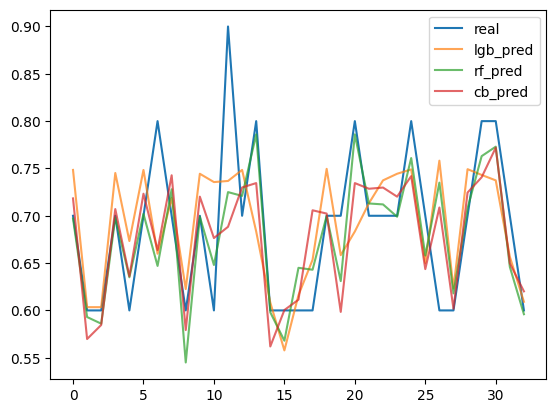

In [25]:
plt.plot(val_y.values, label='real')
plt.plot(lgb_pred, label='lgb_pred', alpha=0.7)
plt.plot(rf_pred, label='rf_pred', alpha=0.7)
plt.plot(cb_pred, label='cb_pred', alpha=0.7)
plt.legend()
plt.show()

이상치를 잘 맞추지 못하는 것 빼고는 괜찮은 것 같음 (사실 이상치를 잘 안 맞춰도 되긴 함)

### model importance

In [26]:
rf_feature_importance = rf_model.feature_importances_
rf_top_features_idx = rf_feature_importance.argsort()[-len(pvalue_features):][::-1]
rf_top_features = tr_x.columns[rf_top_features_idx].tolist()

In [27]:
print(rf_top_features)

['acidity', 'body', 'sweetness', 'roasting_point', '블렌딩', '로스팅']


### permutation importance

In [28]:
rf_perm_importance = permutation_importance(rf_model, val_x, val_y, n_repeats=50, random_state=42)

In [29]:
rf_perm_top_features_idx = rf_perm_importance.importances_mean.argsort()[-len(pvalue_features):][::-1]
rf_perm_top_features = tr_x.columns[rf_perm_top_features_idx].tolist()

In [30]:
print(rf_perm_top_features)

['acidity', 'body', 'sweetness', '블렌딩', '매력', '향미']


구한 집합들의 교집합을 구해보자.

In [31]:
common_features = list(set(rf_perm_top_features) & set(rf_top_features) & set(pvalue_features))
print(common_features)

['body', 'acidity', 'sweetness']


## 최종 모델 성능 실험

In [32]:
rf_perm_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_perm_model.fit(tr_x[rf_perm_top_features], tr_y)

rf_feat_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_feat_model.fit(tr_x[rf_top_features], tr_y)

rf_pval_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pval_model.fit(tr_x[pvalue_features], tr_y)

rf_common_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_common_model.fit(tr_x[common_features], tr_y)

rf_perm_pred = rf_perm_model.predict(val_x[rf_perm_top_features])
rf_feat_pred = rf_feat_model.predict(val_x[rf_top_features])
rf_pval_pred = rf_pval_model.predict(val_x[pvalue_features])
rf_common_pred = rf_common_model.predict(val_x[common_features])

print("perm:", mean_squared_error(val_y, rf_perm_pred))
print("feat:", mean_squared_error(val_y, rf_feat_pred))
print("pval:", mean_squared_error(val_y, rf_pval_pred))
print("common:", mean_squared_error(val_y, rf_common_pred))

perm: 0.0031786324346620917
feat: 0.002854635012053101
pval: 0.003040653757119608
common: 0.004201863503029189


feature importance 피처들을 활용했을 경우 가장 성능이 좋으므로 해당 피처들을 차례로 넣어가면서 최적의 개수를 찾아보자.

In [33]:
top_features_idx = rf_feature_importance.argsort()[::-1]
top_features = tr_x.columns[top_features_idx].tolist()

In [34]:
best_metric = np.inf
best_features = [None]

for i in range(1, len(top_features) + 1):
    model = RandomForestRegressor(n_estimators=100, random_state=42)    
    tmp_features = top_features[:i]
    model.fit(tr_x[tmp_features], tr_y)
    pred = model.predict(val_x[tmp_features])
    mse = mean_squared_error(val_y, pred)

    if mse < best_metric:
        prev_features = best_features
        prev_metric = best_metric

        print(f"best features length : {len(tmp_features)} (previous : {len(prev_features)}) || best metric : {round(best_metric, 5)} -> {round(mse, 5)} (previous : {round(prev_metric, 5)})", end='\r')
        
        best_features = tmp_features
        best_metric = mse
        best_i = i

    # early stop
    if i - best_i > 10:
        break

In [35]:
print(f"best_features : {best_features}")
print(f"best_mse : {round(best_metric, 5)}")
print(f"previous_features : {prev_features}")
print(f"previous_mse : {round(prev_metric, 5)}")

best_features : ['acidity', 'body', 'sweetness', 'roasting_point', '블렌딩', '로스팅', '향미', '산미', '매력']
best_mse : 0.00269
previous_features : ['acidity', 'body', 'sweetness', 'roasting_point', '블렌딩', '로스팅', '향미']
previous_mse : 0.00271


최적의 피처는 ['acidity', 'body', 'sweetness', 'roasting_point', '블렌딩', '로스팅', '향미', '산미', '매력'] 라고 할 수 있음.

In [36]:
model = RandomForestRegressor(n_estimators=100, random_state=42)   
model.fit(tr_x[best_features], tr_y)
pred = model.predict(val_x[best_features])
mse = mean_squared_error(val_y, pred)
print(mse)

0.002691833803339517


iteration 횟수만 조절해보자.

In [37]:
best_metric = np.inf

for iters in [50, 60, 70, 80, 90, 100, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]:
    model = RandomForestRegressor(n_estimators=iters, random_state=42)   
    model.fit(tr_x[best_features], tr_y)
    pred = model.predict(val_x[best_features])
    mse = mean_squared_error(val_y, pred)

    if round(mse,5) < round(best_metric,5):
        print(f"best iter : {iters} || best metric : {round(best_metric, 5)} -> {round(mse, 5)}", end='\r')
        best_metric = mse

In [38]:
model = RandomForestRegressor(n_estimators=250, random_state=42)   
model.fit(tr_x[best_features], tr_y)
pred = model.predict(val_x[best_features])
mse = mean_squared_error(val_y, pred)
print(mse)

0.0025488283832062007


In [39]:
X_train = non_na_df.drop(columns='aroma')
y_train = non_na_df['aroma']

X_test = na_df.drop(columns='aroma')
y_test = na_df['aroma']

In [40]:
final_model = RandomForestRegressor(n_estimators=250, random_state=42)   
final_model.fit(X_train[best_features], y_train)
pred = np.round(final_model.predict(X_test[best_features]),1) * 10

In [41]:
items.loc[y_test.index, 'aroma'] = pred

In [42]:
items['aroma'].isna().sum()

0

In [43]:
with open('./aroma_imputator.pkl', 'wb') as file:
    pickle.dump(model, file)

## Predict

In [44]:
with open('./aroma_imputator.pkl', 'rb') as file:
    imputator = pickle.load(file)

In [45]:
pred = np.round(imputator.predict(X_test[best_features]),1) * 10